# ESMValCore Minimal example

The following example illustrate how to leverage ESMValCore, the engine powering the ESMValTool collection of recipes, to quickly load CMIP data and do some analysis on them.
This is a minimal example, we first look at how we can quickly find and plot a map and a timeseries.



# Plot a 2D field on a map

In [54]:
from esmvalcore.dataset import Dataset

## Load data

Here we look for some surface temperature data from an historical model experiment

In [55]:
dataset = Dataset(
    short_name='tas',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    dataset='ACCESS-ESM1-5',
    grid="gn"
)

As you can see ESMValCore has found one file on Gadi that contains the surface temperature output for the time range specified.
By default, the data is loaded in an Iris Cube, sorry Xarray proponent, ESMValCore is build on Iris, but don't go away to fast...

## Processing

In [56]:
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units

In [57]:
cube = dataset.load()

temperature_1990_1991 = extract_time(cube, start_year=1990, start_month=1, start_day=1, end_year=1991, end_month=1, end_day=1) 
temperature_weighted_mean = climate_statistics(temperature_1990_1991, operator="mean")
temperature_celcius = convert_units(temperature_weighted_mean, units="degrees_C")

## Plot

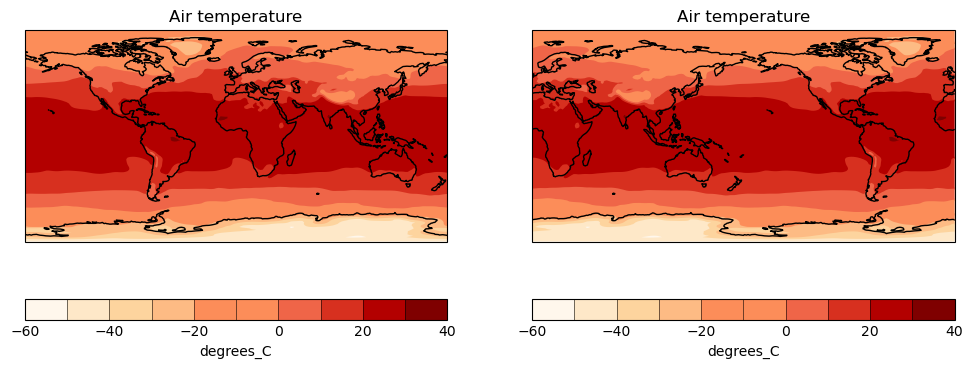

In [58]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

import iris
import iris.plot as iplt
import iris.quickplot as qplt

# Load a Cynthia Brewer palette.
brewer_cmap = colormaps["brewer_OrRd_09"]

# Create a figure
plt.figure(figsize=(12, 5))

# Plot #1: countourf with axes longitude from -180 to 180
proj = ccrs.PlateCarree(central_longitude=0.0)
plt.subplot(121, projection=proj)
qplt.contourf(temperature_weighted_mean, brewer_cmap.N, cmap=brewer_cmap)
plt.gca().coastlines()

# Plot #2: contourf with axes longitude from 0 to 360
proj = ccrs.PlateCarree(central_longitude=-180.0)
plt.subplot(122, projection=proj)
qplt.contourf(temperature_weighted_mean, brewer_cmap.N, cmap=brewer_cmap)
plt.gca().coastlines()
plt.savefig("test.png",bbox_inches='tight')
iplt.show()

## Hovmoller Diagram

In [ ]:
cube = extract_time(cube, start_year=1990, start_month=1, start_day=1, end_year=1991, end_month=1, end_day=1) 
cube = cube.extract(iris.Constraint(latitude=lambda v: -5 < v < 5))
cube = cube.collapsed("latitude", iris.analysis.MEAN)

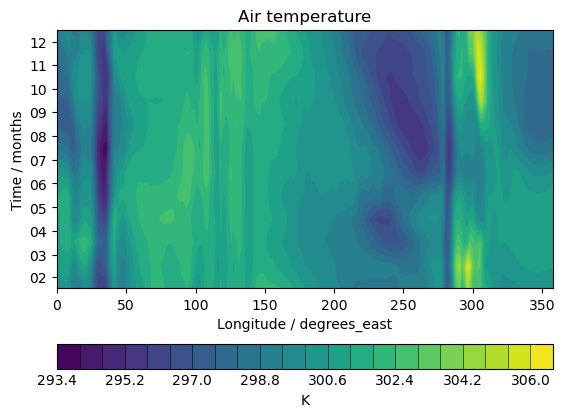

In [60]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import iris.quickplot as qplt


# Now that we have our data in a nice way, lets create the plot
# contour with 20 levels
qplt.contourf(cube, 20)

# Put a custom label on the y axis
plt.ylabel("Time / months")

# Stop matplotlib providing clever axes range padding
plt.axis("tight")

# As we are plotting annual variability, put years as the y ticks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())

# And format the ticks to just show the year
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter("%m"))

iplt.show()

## Wind speed above Australia

### Load Datasets

In [61]:
ua = Dataset(
    short_name='ua',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    dataset='ACCESS-ESM1-5',
    timerange="19900101/19910101",
    grid="gn"
)
va = Dataset(
    short_name='va',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    dataset='ACCESS-ESM1-5',
    timerange="19900101/19910101",
    grid="gn"
)

ua = ua.load()
va = va.load()

## Process data

In [62]:
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_levels
from esmvalcore.preprocessor import extract_month

In [63]:
ua_australia = extract_region(ua, start_longitude=105, end_longitude=160, start_latitude=-45, end_latitude=-9) 
ua_australia_10000 = extract_levels(ua_australia, levels=10000, scheme="linear")
ua_australia_10000_jan = extract_month(ua_australia_10000, month=1)


va_australia = extract_region(va, start_longitude=105, end_longitude=160, start_latitude=-45, end_latitude=-9) 
va_australia_10000 = extract_levels(va_australia, levels=10000, scheme="linear")
va_australia_10000_jan = extract_month(va_australia_10000, month=1)

## Plot

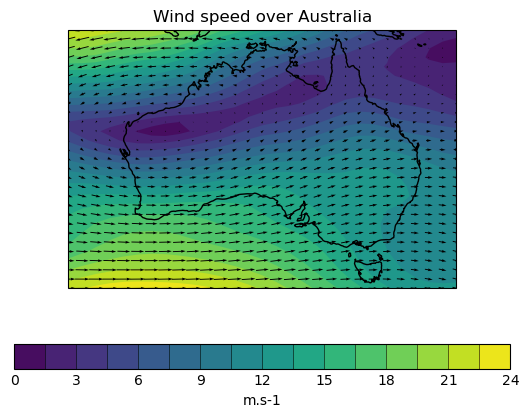

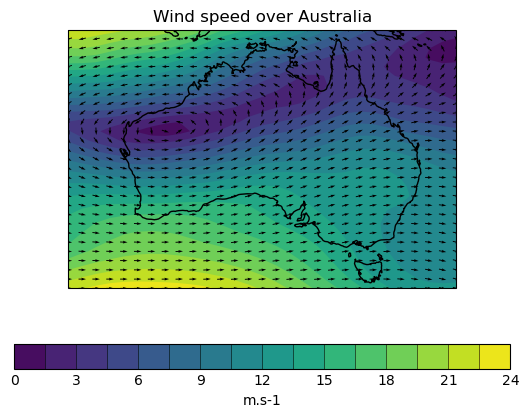

In [64]:
import cartopy


uwind = ua_australia_10000_jan
vwind = va_australia_10000_jan

# Create a cube containing the wind speed.
windspeed = (uwind**2 + vwind**2) ** 0.5
windspeed.rename("windspeed")

# Plot the wind speed as a contour plot.
qplt.contourf(windspeed, 20)

plt.gca().add_feature(cartopy.feature.COASTLINE)

# Add arrows to show the wind vectors.
iplt.quiver(uwind, vwind, pivot="middle")

plt.title("Wind speed over Australia")
qplt.show()

# Normalise the data for uniform arrow size.
u_norm = uwind / windspeed
v_norm = vwind / windspeed

# Make a new figure for the normalised plot.
plt.figure()

qplt.contourf(windspeed, 20)
plt.gca().add_feature(cartopy.feature.COASTLINE)

iplt.quiver(u_norm, v_norm, pivot="middle")

plt.title("Wind speed over Australia")
qplt.show()

## Air Potential Temperature (3d data) Transect
### Load Dataset

In [65]:
ta = Dataset(
    short_name='ta',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    dataset='ACCESS-ESM1-5',
    timerange="19900101/19910101",
    grid="gn"
)

ta = ta.load()

## Process data

In [66]:
from esmvalcore.preprocessor import extract_transect

In [67]:
temperature_jan = extract_month(ta, month=1)
temperature_transect = extract_transect(cube=temperature_jan, longitude=15.)

## Plot

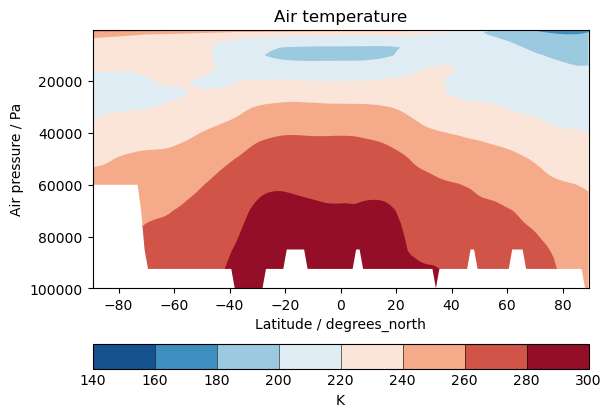

In [68]:
plt.figure()

qplt.contourf(
    temperature_transect,
    #coords=["grid_longitude", "model_level_number"],
    cmap="RdBu_r",
)
iplt.show()

## Australia mean temperature timeseries

### Load Data

In [48]:
ts = Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    dataset='ACCESS-ESM1-5',
    grid="gn"
)

ts = ts.load()

## Process data

In [69]:
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import convert_units

In [70]:
ts_australia = extract_region(ts, start_longitude=105, end_longitude=160, start_latitude=-45, end_latitude=-9) 
ts_australia = area_statistics(ts_australia, operator="mean")
ts_australia = annual_statistics(ts_australia, operator="mean")
ts_australia = convert_units(ts_australia, units="degrees_C")

## Plot

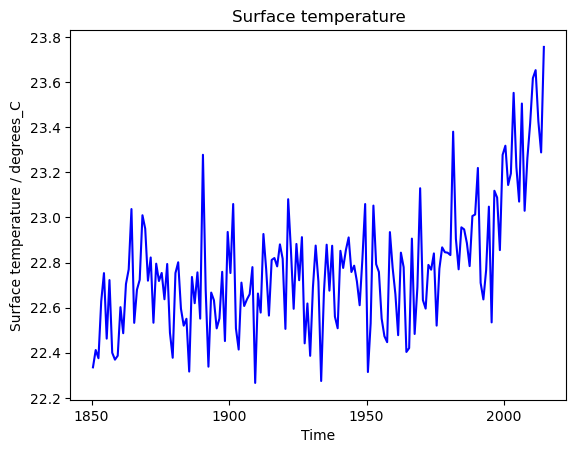

In [51]:
qplt.plot(ts_australia, label="E1 scenario", lw=1.5, color="blue")